In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk

In [2]:
data = pd.read_csv("./steam-200k.csv", delimiter=',', header=None)
#random shuffle to lose any sorting bias
play_data = sk.utils.shuffle(data[data[2].str.contains('play')][3])

In [3]:
#===Pareto parameters (likelihood)===
#xm=0.1 hours is the minimum playtime seen in the set (scale), and k=1.01 (shape) is found by setting the mean of the pareto to 7 hours (initial guess for the average playtime of a generic game)
xm = 0.1 #scale - fixed
k = 1.01 #shape - model parameter (initial guess)
#===Gamma parameters (prior)===
alpha = 1 #shape - arbitrary (simplest choice, as the gamma is fully defined for alpha >= 1)
beta = 0.99 #rate - for the mean of the gamma mu=alpha/beta to be equal to k=1.01

In [4]:
#Hyperparameter update: at each xi we see (a new game duration for some player) update the values for alpha and beta.
#See https://en.wikipedia.org/wiki/Conjugate_prior#When_likelihood_function_is_a_continuous_distribution
#There might be nicer ways to write this, but you get the gist.
hyperparams = [(alpha, beta)]
def update_alpha(n):
    alpha = hyperparams[0][0]
    return alpha + n
def update_beta(xi, ors):
    beta = hyperparams[0][1]
    updated_ors = ors + math.log(xi/xm)
    return (updated_ors, beta + ors)
ors = 0 #order ratio sum
for i, xi in enumerate(play_data):
    updated_alpha = update_alpha(i)
    ors, updated_beta = update_beta(xi, ors)
    hyperparams.append((updated_alpha, updated_beta))

In [5]:
#(the collection of updates of the (alpha, beta) parameters of the Gamma posterior distribution; attention, this is not the posterior predictive distribution, which is not listed); at each time i these 
hyperparams

4, 1108.86409232702),
 (275, 1113.8945302484124),
 (276, 1118.2765568830862),
 (277, 1122.2838900683187),
 (278, 1123.3825023569868),
 (279, 1125.174261826215),
 (280, 1129.837700920327),
 (281, 1133.2049967503135),
 (282, 1137.363879833673),
 (283, 1138.973317746107),
 (284, 1142.3406135760936),
 (285, 1146.915324554597),
 (286, 1149.8597635337635),
 (287, 1152.6929768778198),
 (288, 1152.6929768778198),
 (289, 1162.1641418680779),
 (290, 1163.262754156746),
 (291, 1165.9018114863613),
 (292, 1170.1065041057523),
 (293, 1176.0979686528603),
 (294, 1178.5828753026483),
 (295, 1181.6739177560066),
 (296, 1185.9505838750226),
 (297, 1191.218442034086),
 (298, 1196.1456957192431),
 (299, 1197.9374551884712),
 (300, 1199.0360674771393),
 (301, 1204.3831750078568),
 (302, 1210.269279039307),
 (303, 1214.2395709528591),
 (304, 1218.8839618520005),
 (305, 1219.5771090325604),
 (306, 1224.162076511231),
 (307, 1224.8552236917908),
 (308, 1228.0332775221386),
 (309, 1229.979187671194),
 (310, 1

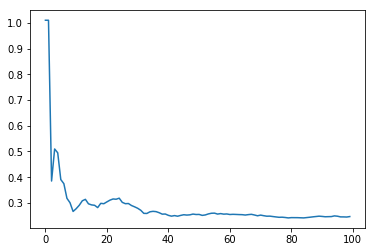

In [6]:
#we can say the prior stabilizes pretty fast, already around 100 samples
plt.plot([alpha/beta for alpha,beta in hyperparams[0:100]])

In [7]:
import numpy as np
print("Final estimates for posterior hyperparams (Gamma): {}".format(hyperparams[-1]))
eps = np.random.gamma(shape=hyperparams[-1][0],scale=1/hyperparams[-1][1])
print("Random estimate Pareto shape (Gamma sample): {}".format(eps))
print("Posterior mean: {} (shape <= 1)".format("infty"))
print("Posterior variance: {} (shape <= 2)".format("infty"))

Final estimates for posterior hyperparams (Gamma): (70489, 274318.61854130786)
Random estimate Pareto shape (Gamma sample): 0.2576647039608968
Posterior mean: infty (shape <= 1)
Posterior variance: infty (shape <= 2)


sample test mean: 0.1354246367254725
sample test std: 0.19710268422399266
data mean: 48.87806324391145
data std: 229.33360924617722
error - mean: 48.74263860718493
error - std: 229.3334930005069


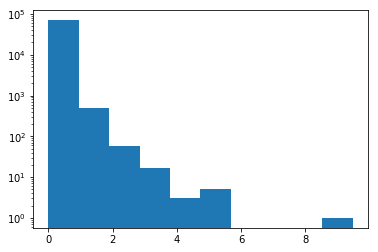

In [8]:
from scipy.stats import genpareto
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
posterior_sample = genpareto.rvs(c=eps, scale=xm,size=len(play_data))
ax.hist(posterior_sample, log=True)
print("sample test mean: {}".format(np.mean(posterior_sample)))
print("sample test std: {}".format(np.std(posterior_sample)))
print("data mean: {}".format(np.mean(play_data)))
print("data std: {}".format(np.std(play_data)))
print("error - mean: {}".format(np.mean((play_data.values-posterior_sample))))
print("error - std: {}".format(np.std((play_data.values-posterior_sample))))

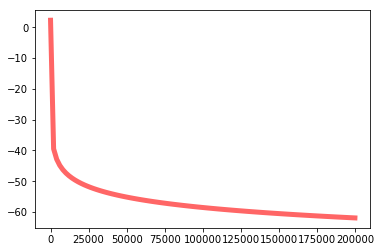

In [17]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(0, 200000, 100)
ax.plot(x, np.log(genpareto.pdf(x, c=eps, scale=xm)),'r-', lw=5, alpha=0.6, label='genpareto pdf')

(array([7.0018e+04, 3.4000e+02, 7.8000e+01, 3.0000e+01, 1.3000e+01,
        6.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([1.000000e-01, 1.175490e+03, 2.350880e+03, 3.526270e+03,
        4.701660e+03, 5.877050e+03, 7.052440e+03, 8.227830e+03,
        9.403220e+03, 1.057861e+04, 1.175400e+04]),
 <a list of 10 Patch objects>)

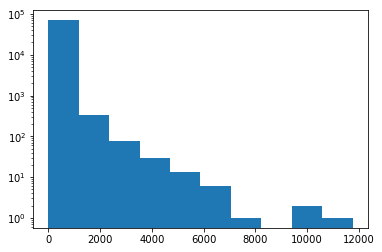

In [10]:
plt.hist(play_data.values, log=True)

In [11]:
#The realized Pareto distribution above is thus our data generating process: at each time t it spits out, for a given player and videogame, the playtime.
#Note: we did not [0,1]-scaled on purpose for clarity, but doing so has you work with smaller numbers of course, no logs etc.